In [2]:
import numpy as np
import pandas as pd
from pylab import mpl, plt
import os
import seaborn as sns
from sklearn.cluster import KMeans

os.chdir('data')

As in the first work we get the historic end-of-day closing prices of four stocks.

,AAPL,IBM,MSFT,NKE
date,,,,
2014-02-21,68.9821,152.3849,33.7870,36.0905
2014-02-24,69.2841,152.9351,33.5290,36.7323
2014-02-25,68.5631,152.7517,33.3956,36.8597
2014-02-26,67.9446,153.4436,33.3333,37.0060
2014-02-27,69.2999,154.4523,33.6803,36.9302


,AAPL,IBM,MSFT,NKE
min,67.94,104.41,33.33,33.53
mean,128.63,140.75,62.48,55.82
max,230.28,166.96,114.62,85.40
std,38.22,12.80,23.72,12.12


<Axes: xlabel='date'>

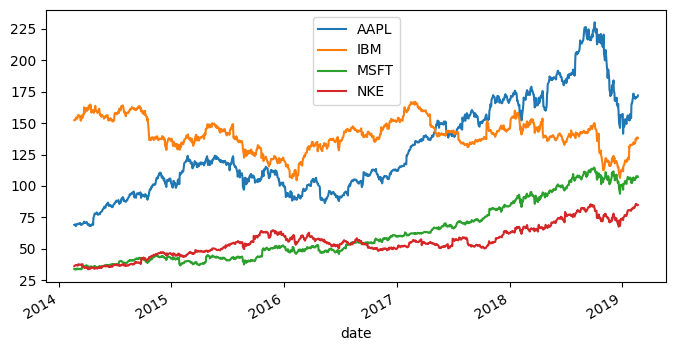

In [3]:
# get EOD data
eod = pd.DataFrame()

for name in ['AAPL','IBM','MSFT','NKE']:
    raw = pd.read_csv(name+'.csv', index_col=0, parse_dates=True)
    raw = raw[['close']]
    raw.rename({'close': name}, axis=1, inplace=True)
    eod = pd.concat([eod, raw], axis=1)

display(eod.head())
display(eod.aggregate([min, np.mean, max, np.std]).round(2))
eod.plot(figsize=(8,4))

SUBSECTION 4.1

As a first strategy we consider the classic dual simple moving averages, ie. having a moving average with a small window and another with a large on.
The strategy says to buy when the small SMA is stronger than the large one and sell otherwise.
This is shown in the plot by the dotted line which shows buying at 1 and selling at -1.
For a first example we set the small window to be 42 closes (shown in green in the diagram) and the large window to 252 closes (in red).

<Axes: >

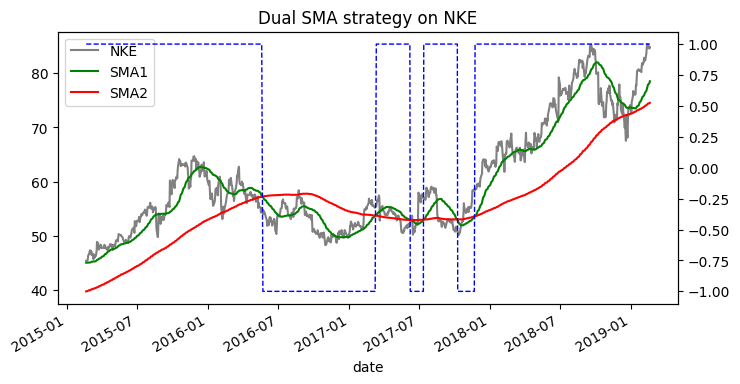

In [4]:
# Dual simple moving averages
nke = pd.DataFrame(eod['NKE'])
nke['SMA1'] = nke.NKE.rolling(window=42).mean()
nke['SMA2'] = nke.NKE.rolling(window=252).mean()

fig, ax = plt.subplots()
fig.set_size_inches(8,4)

nke.dropna(inplace=True,axis=0,how='any')

nke.plot(ax=ax, style=['grey','g','r'], title='Dual SMA strategy on NKE')

nke['strategy'] = np.where(nke.SMA1 > nke.SMA2, 1, -1)

nke.strategy.plot(ax=ax, secondary_y='strategy', style='b--',lw=1)

Now that we have a strategy we want to consider whether or not it has better returns than simply investing in NKE at the start and waiting.
Clearly the strategy is not great since the returns are smaller than having simply done nothing.

In [5]:
# compute returns
nke['ret'] = np.log(nke.NKE / nke.NKE.shift(1))
print(f"Investing and doing nothing returns {round(np.exp(nke.ret.sum()),3)}.")

nke['SMA_ret'] = nke.ret * nke.strategy.shift(1)
print(f"Dual SMA strategy returns {round(np.exp(nke.SMA_ret.sum()),3)}.")

Investing and doing nothing returns 1.871.
Dual SMA strategy returns 1.142.


The window sizes were rather arbitrary and it would be interesting to find which pair of window sizes would offer the best returns.
For this we simply brut force within a reasonable range.
We also implement an idea of cost to disadvantage the strategies that would simply try to buy and sell as fast as possible whenever the market changed.
This cost is simply applied as a deduction to the total return for everytime we have to buy or sell.

,small_w,large_w,returns
100,45,120,181.556303
124,55,120,179.556303
160,70,120,179.556303
136,60,120,179.556303
172,75,120,179.556303


Text(0.5, 1.0, 'Returns by window size pairs')

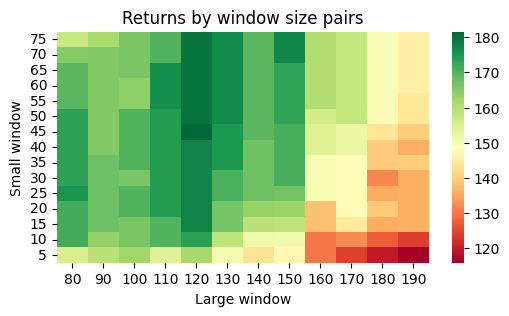

In [6]:
# brute force for best windows

nke = pd.DataFrame(eod['NKE'])

returns = pd.DataFrame(columns=['small_w','large_w','returns'])

for small_w in range(5,80, 5):
    for large_w in range(80, 200, 10):
        nke = pd.DataFrame(eod['NKE'])
        nke['SMA1'] = nke.NKE.rolling(window=small_w).mean()
        nke['SMA2'] = nke.NKE.rolling(window=large_w).mean()

        nke.dropna(inplace=True,axis=0,how='any')

        nke['strategy'] = np.where(nke.SMA1 > nke.SMA2, 1, -1)

        nke['cost'] = np.abs(nke.strategy - nke.strategy.shift(1))

        nke['ret'] = np.log(nke.NKE / nke.NKE.shift(1))

        total_ret = np.exp(nke.ret.sum())*nke.NKE[-1] - nke.cost.sum()

        returns = pd.concat([returns, pd.DataFrame(
            {'small_w': small_w,
             'large_w': large_w,
             'returns': total_ret} ,index=[0])],ignore_index=True)

display(returns.sort_values(by='returns',ascending=False).head(5))

pivot = returns.pivot_table(values='returns',index='small_w',columns='large_w')
pivot.sort_index(ascending=False,inplace=True)

fig, ax = plt.subplots()
fig.set_size_inches(6,3)
sns.heatmap(ax=ax,data=pivot,cmap='RdYlGn')
ax.set_xlabel('Large window')
ax.set_ylabel('Small window')
ax.set_title('Returns by window size pairs')

Looking at the best strategies we see the small window being 45 and the large window being 120 is optimal, however many of the strategies with the same large window of 120 are really almost as strong.
Finally we finishing by looking at this optimal strategy over time.

<Axes: >

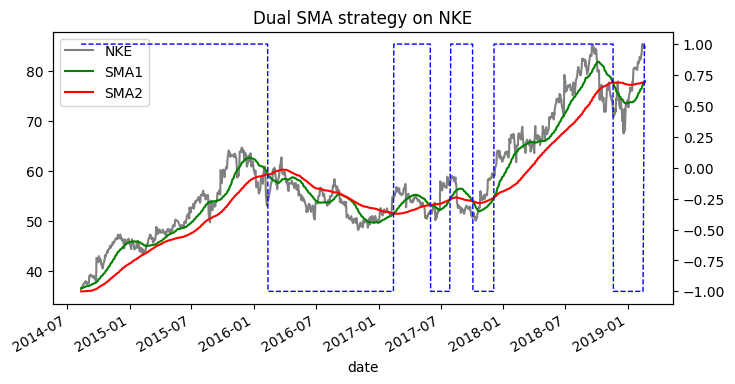

In [7]:
# Dual simple moving averages
nke = pd.DataFrame(eod['NKE'])
nke['SMA1'] = nke.NKE.rolling(window=45).mean()
nke['SMA2'] = nke.NKE.rolling(window=120).mean()

fig, ax = plt.subplots()
fig.set_size_inches(8,4)

nke.dropna(inplace=True,axis=0,how='any')

nke.plot(ax=ax, style=['grey','g','r'], title='Dual SMA strategy on NKE')

nke['strategy'] = np.where(nke.SMA1 > nke.SMA2, 1, -1)

nke.strategy.plot(ax=ax, secondary_y='strategy', style='b--',lw=1)

SUBSECTION 4.2

Now we look at the returns of the IBM stock using as instruments the same returns but lagged by 1 and 2 places respectively.
The idea being to try to use the momentum of the stock, this would work if a stock going up one or two days in a row implies that it has a good chance of going up again.
The momentum could also imply a change of direction, maybe caused by a increase two days ago and a decrease one day ago.

First we consider the distribution of the returns against those of the lagged returns.

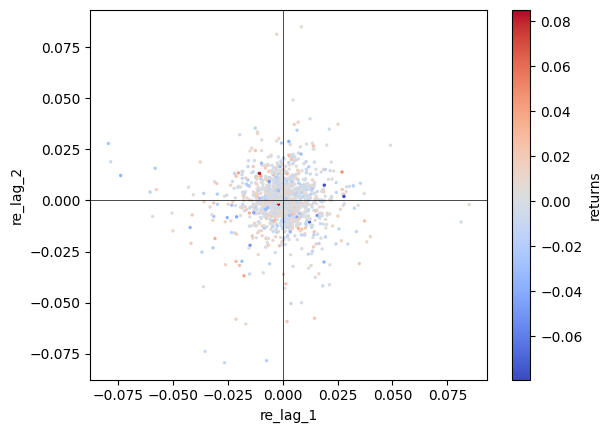

In [8]:
ibm = pd.DataFrame(eod['IBM'])
ibm['returns'] = np.log(ibm.IBM / ibm.IBM.shift(1))
ibm['re_lag_1'] = ibm.returns.shift(1)
ibm['re_lag_2'] = ibm.returns.shift(2)
ibm.dropna(inplace=True)

fig, ax = plt.subplots()
ibm.plot(ax=ax,kind='scatter',x='re_lag_1',y='re_lag_2',
         c='returns',colormap='coolwarm',s=2)
ax.axhline(y=0,lw=0.5,c='black')
ax.axvline(x=0,lw=0.5,c='black')

Now we try to cluster these data points into two sets, essentially using the lagged data to predict the real data.
We fit a KMeans model, ie. a model which minimises the variance within each of the two clusters.

As a result we see that the strategy is quite close to predicting a positive return as long as neither of the lag of more negative than the other is positive, with a slight tolerance as long as it is the 1 day lag which is positive.

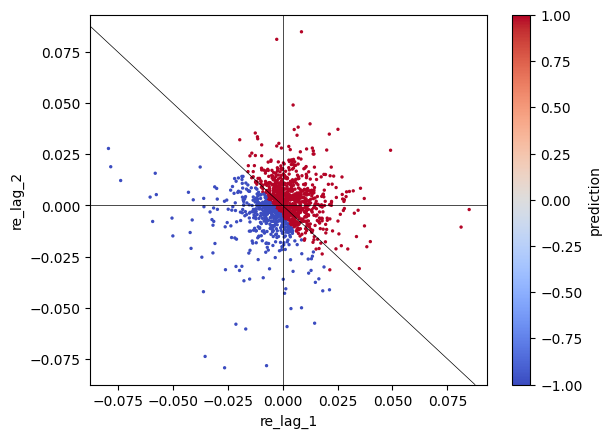

In [16]:
model = KMeans(n_clusters=2, random_state=0, n_init='auto')
lag_cols = ['re_lag_1','re_lag_2']
model.fit(ibm[lag_cols])
ibm['prediction'] = model.predict(ibm[lag_cols])
ibm.prediction = np.where(ibm.prediction==1,-1,1)
fig, ax = plt.subplots()
ibm.plot(ax=ax,kind='scatter',x='re_lag_1',y='re_lag_2',
         c='prediction',cmap='coolwarm',s=2)
ax.axline((0,0),slope=0,lw=0.5,c='black')
ax.axline((0,0),slope=np.inf,lw=0.5,c='black')
ax.axline((0,0),slope=-1,lw=0.5,c='black',linestyle='-')

Finally we use this strategy to see if it gives better returns than passively investing.

returns     0.903427
strat_re    1.351905
dtype: float64

Text(0.5, 1.0, 'Passive vs. cluster strategy returns')

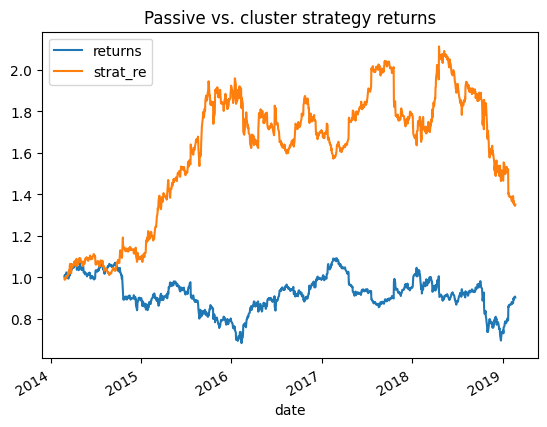

In [70]:
ibm['strat_re'] = ibm.prediction * ibm.returns
display(np.exp(ibm[['returns','strat_re']].sum()))
fig, ax = plt.subplots()
np.exp(ibm[['returns','strat_re']].cumsum()).plot(ax=ax)
ax.set_title('Passive vs. cluster strategy returns')
